# Overview

For the missing values of the categorical variables including the boolean variables the most frequent mode is choosen. For numerical features the mean of the feature over all entries is taken.

The features "Concert Goer ID" and "Id" are transformed into numerical values. The entries for the feature "Concert Attendance" are cleaned.  Some entries were wrongly inputed including a factor of 10 to the power of 3.

The categorical variable "Concert Goer Country of Origin" was regrouped, so that all modes with a frequency < 0.01 are grouped into the new mode "Other".

Three new boolean features are created. "Rain_Inside" gives information if it was raining during the concert and if the concert was inside. "Same Country" is giving information if the convert goer and the palying band were from the same country. The feature "standing_small" is giving information if the convert was seated or not and if the concert goer is small in height (< 165cm).

The categorical variables are one-hot-encoded so that in total 87 features are used for the two classifiers Random Forest and XGBoost.
A recommender system was created by creating a sparse matrix m x n with m as the number of concert goers in the dataset and n the number of different concerts.
The target labels were transformed into votings from 0-3 and the sparse matrix was imputed with a MatrixFactorization algorithm of the fanyimpute libary.

Random Forest and XGBoost were fitted on the data with a 3-fold validation in a randomized hyperparameter search.
The best performing models are taken to create the final prediction.
It consists of the recommendation, according to the entry in the imputed matrix for the specific concert and concert goer, the prediciton of the Random Forest and the XGBoost model.
The final prediction for a single datapoint is the majority of the three predictions. For an equality in the outputs, the prediction of the XGBoost model is taken, due to the best performance on its own.

In [ ]:
!pip install fancyimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 9.1 MB/s 
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29898 sha256=fc08297834bfaaa3d5438c9dc044835a1f180bad6b4b6e3182f18f85960ccd83
  Stored in directory: /root/.cache/pip/wheels/e3/04/06/a1a7d89ef4e631ce6268ea2d8cde04f7290651c1ff1025ce68
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=67d869de5cf5cd245b98b9e6fb1195a21ce93e0911c5aeedb4c18f54f1f6f707
  Stored in directory: /root/.cache/pip/wheels/72/21/a8/a045cacd9838abd5643f6bfa852c0796a99d6b1494760494e0
Successfully built fancyimpute knnimpute


# 1- Best predictions generation
Run all the cells in this section to generate the final predictions. 

**Important** :  As mentionned in the readme : To run the notebook, make sure you have files named train.csv and test.csv in the runtime environment base folder such that google colab code can access training and test data with urls: ```train.csv``` and ```test.csv```.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import csv

from pprint import pprint

from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


import xgboost as xgb


## 1.1 Feature preprocessing

In [ ]:
# read data and show
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
#select columns to delete
print(df_train["Concert Enjoyment"].unique())
drop_keys = []
df_train.head()

['Did Not Enjoy' 'Enjoyed' 'Worst Concert Ever' 'Best Concert Ever']


,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
0,ConcertExperience_180106,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,concert_goer_1985,140.0,Paraguay,Did Not Enjoy
1,ConcertExperience_146268,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,concert_goer_1874,158.0,United Kingdom (UK),Enjoyed
2,ConcertExperience_128743,Ron Talent,Rock n Roll,Canada,1955.0,NaN,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,concert_goer_442,159.0,United States of America (USA),Did Not Enjoy
3,ConcertExperience_140839,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,concert_goer_1149,150.0,Canada,Worst Concert Ever
4,ConcertExperience_19149,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,concert_goer_930,166.0,United Kingdom (UK),Did Not Enjoy


In [ ]:
cat_features = ["Band Name", "Band Genre", "Band Country of Origin", "Concert Goer Country of Origin", "Id", "Concert Goer ID", "Inside Venue", "Seated"]
#df[cat_features] = df[cat_features].fillna(value=df[cat_features].mean())
#df[cat_features] =  df[cat_features].fillna(df[cat_features].mean())
#df = df.fillna(df.mode().iloc[0])
df_train[cat_features] = df_train[cat_features].fillna(df_train[cat_features].mode().iloc[0])
df_test[cat_features] = df_test[cat_features].fillna(df_test[cat_features].mode().iloc[0])
df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_test.mean())
df_train.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Id                                0
Band Name                         0
Band Genre                        0
Band Country of Origin            0
Band Debut                        0
Concert ID                        0
Concert Attendance                0
Inside Venue                      0
Rain                              0
Seated                            0
Personnality Trait 1              0
Personnality Trait 2              0
Personnality Trait 3              0
Personnality Trait 4              0
Concert Goer Age                  0
Concert Goer ID                   0
Height (cm)                       0
Concert Goer Country of Origin    0
Concert Enjoyment                 0
dtype: int64

In [ ]:
cat_features = ["Band Name", "Band Genre", "Band Country of Origin", "Concert Goer Country of Origin", "Id", "Concert Goer ID"]
df_numeric = df_train.drop(cat_features, axis=1)
df_numeric.describe()

,Band Debut,Concert ID,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Height (cm),Goer_ID,CE_ID
count,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000
mean,1985.895053,499.360587,28321.041624,0.030190,-7.776188,-0.017279,0.003432,46.979822,164.660680,999.975888,99963.491818
std,16.323985,287.901068,52112.077188,0.989578,3229.618937,1.002132,1.003746,17.426617,14.329215,576.372315,57722.835456
min,1955.000000,0.000000,54.000000,-3.124408,-293861.500146,-3.275108,-3.287787,16.000000,140.000000,0.000000,0.000000
25%,1976.000000,251.000000,403.000000,-0.630466,-0.696941,-0.707816,-0.694943,32.000000,152.000000,499.000000,49965.750000
50%,1988.000000,499.360587,2980.000000,0.025305,-0.027111,-0.001654,0.009632,47.000000,164.000000,1003.000000,99991.500000
75%,1998.000000,748.000000,22026.000000,0.694111,0.646025,0.678551,0.692939,62.000000,177.000000,1501.000000,149977.250000
max,2014.000000,999.000000,272790.592224,3.628828,325834.016795,3.308810,3.830923,76.000000,190.000000,1999.000000,199999.000000


In [ ]:
# create numeric variables of "Convert Goer ID" and "	ConcertExperience Id"
def getIds(data):
  ids = [str(id).split('_')[-1] for id in data]
  ids = [id.replace('nan','0') for id in ids]
  return ids

def checkSameCountry(x, y):
  if x == y:
    return True
  else:
    return False

def checkSmallSeated(height,seated):
  if height < 165 and seated:
    return True
  else:
    return False

df_train["Goer_ID"] = pd.to_numeric(getIds(df_train["Concert Goer ID"]))
df_train["CE_ID"] = pd.to_numeric(getIds(df_train["Id"]))
df_test["Goer_ID"] = pd.to_numeric(getIds(df_test["Concert Goer ID"]))
df_test["CE_ID"] = pd.to_numeric(getIds(df_test["Id"]))
drop_keys.append("Id")
drop_keys.append("Concert Goer ID")

# resolve error input in convert attendance
df_train["Concert Attendance"] = df_train["Concert Attendance"].apply(lambda x: x/10e3 if x > 500000.0 else x)
df_test["Concert Attendance"] = df_test["Concert Attendance"].apply(lambda x: x/10e3 if x > 500000.0 else x)

# join rare concert goer countries of origin into "Other"
df_train["Concert Goer Country of Origin"] = df_train['Concert Goer Country of Origin'].mask(df_train['Concert Goer Country of Origin'].map(df_train['Concert Goer Country of Origin'].value_counts(normalize=True)) < 0.01, 'Other')
df_test["Concert Goer Country of Origin"] = df_test['Concert Goer Country of Origin'].mask(df_test['Concert Goer Country of Origin'].map(df_test['Concert Goer Country of Origin'].value_counts(normalize=True)) < 0.01, 'Other')

# create new features
df_train["Rain_Inside"] = df_train["Rain"]*df_train["Inside Venue"]
df_train["Same Country"] = df_train[["Concert Goer Country of Origin", "Band Country of Origin"]].apply(lambda x: checkSameCountry(*x), axis=1)
df_train["standing_small"] = df_train[["Height (cm)", "Seated"]].apply(lambda x: checkSmallSeated(*x), axis=1)
df_test["Rain_Inside"] = df_test["Rain"]*df_test["Inside Venue"]
df_test["Same Country"] = df_test[["Concert Goer Country of Origin", "Band Country of Origin"]].apply(lambda x: checkSameCountry(*x), axis=1)
df_test["standing_small"] = df_test[["Height (cm)", "Seated"]].apply(lambda x: checkSmallSeated(*x), axis=1)

labels = ['Best Concert Ever', 'Enjoyed', 'Did Not Enjoy', 'Worst Concert Ever']
colors_labels = {labels[0]: "green", labels[1]:"blue", labels[2]:"orange", labels[3]:"red"}

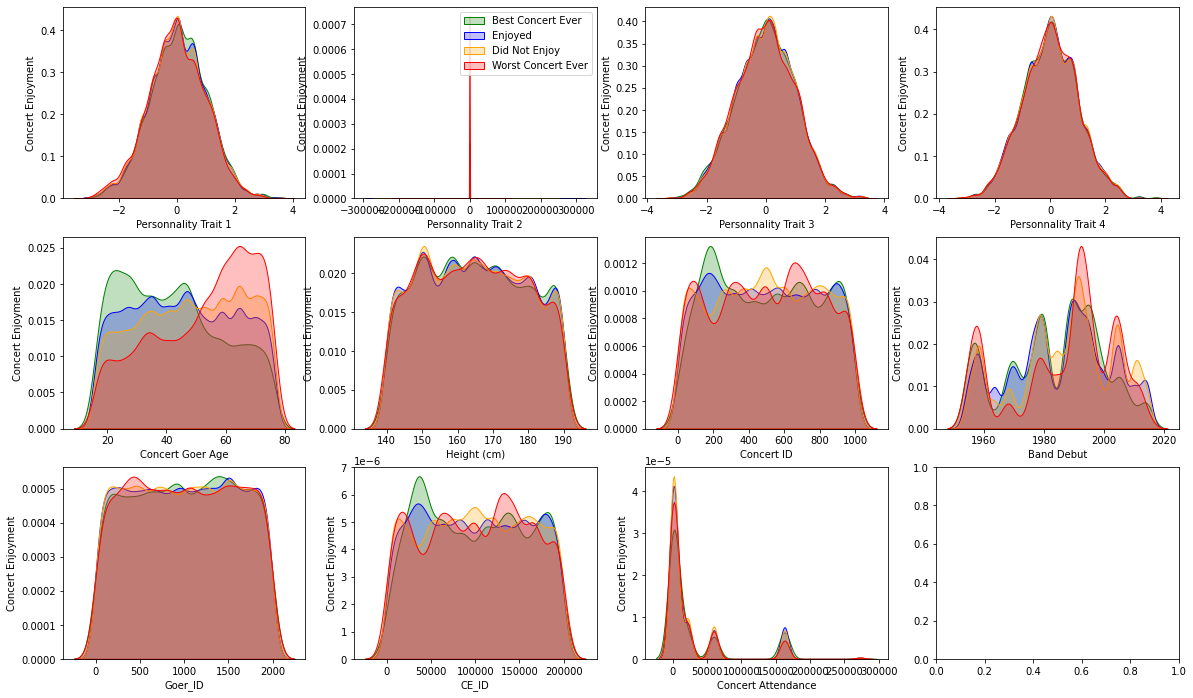

In [ ]:
def plot_numeric_data(df, cat, ax, legend=False):
  for i in range(len(labels)):
    sns.kdeplot(df[df["Concert Enjoyment"]==labels[i]][cat], shade=True, color=colors_labels[labels[i]], label=labels[i], ax=ax)
  ax.set_xlabel(cat)
  ax.set_ylabel("Concert Enjoyment")
  if legend:
    ax.legend()

fig, axes = plt.subplots(3, 4, figsize=(20,12))
plot_numeric_data(df_train, "Personnality Trait 1", axes[0, 0])
plot_numeric_data(df_train, "Personnality Trait 2", axes[0, 1], legend=True)
plot_numeric_data(df_train, "Personnality Trait 3", axes[0, 2])
plot_numeric_data(df_train, "Personnality Trait 4", axes[0, 3])
plot_numeric_data(df_train, "Concert Goer Age", axes[1, 0])
plot_numeric_data(df_train, "Height (cm)", axes[1, 1])
plot_numeric_data(df_train, "Concert ID", axes[1, 2])
plot_numeric_data(df_train, "Band Debut", axes[1, 3])
plot_numeric_data(df_train, "Goer_ID", axes[2,0])
plot_numeric_data(df_train, "CE_ID", axes[2,1])
plot_numeric_data(df_train, "Concert Attendance", axes[2,2])
plt.show()

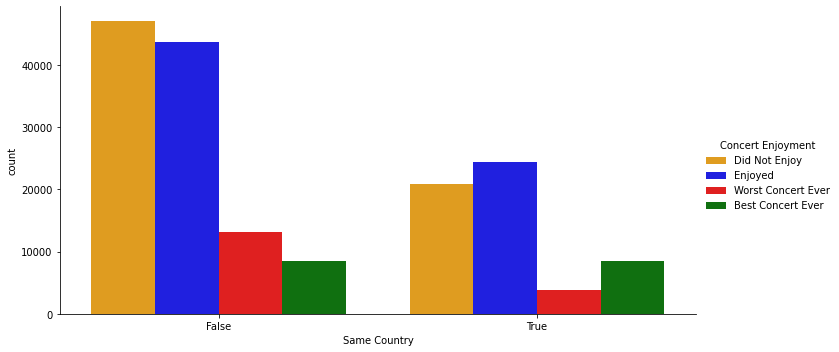

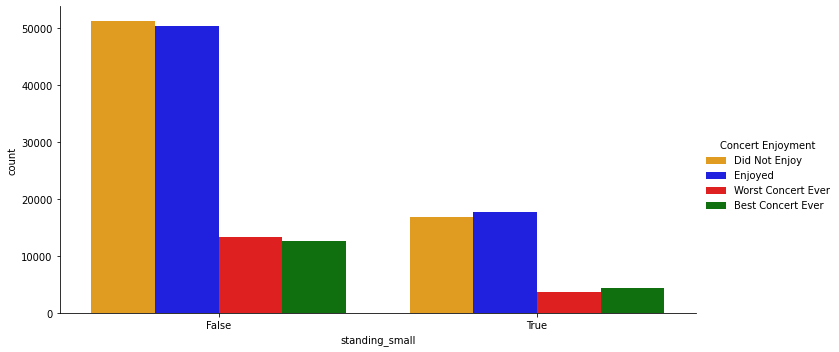

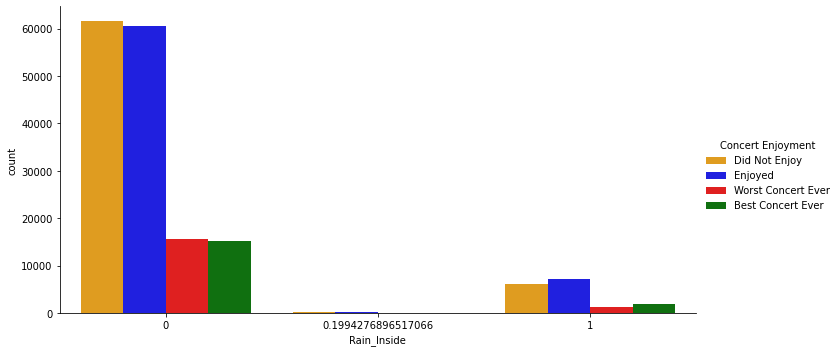

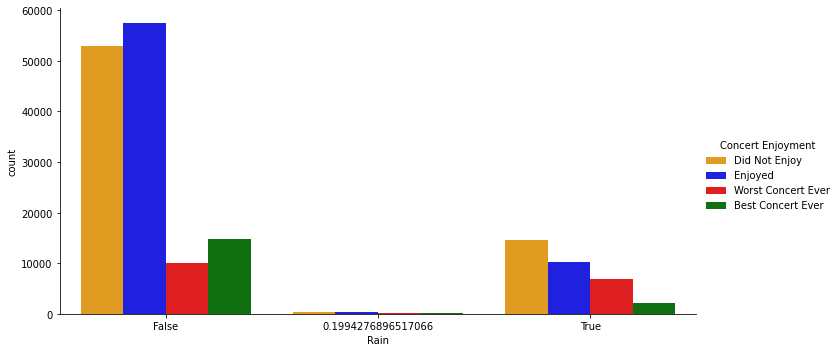

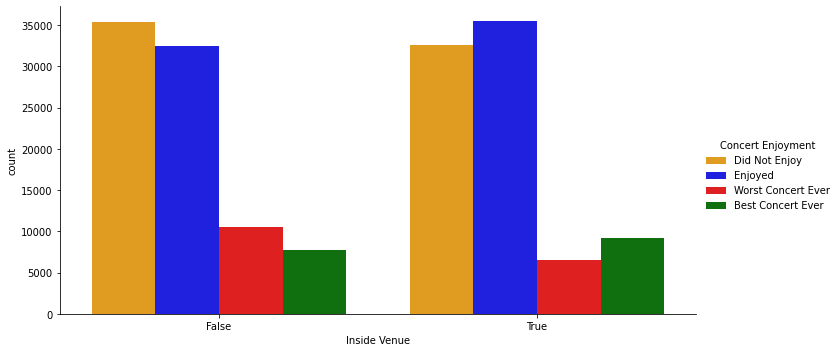

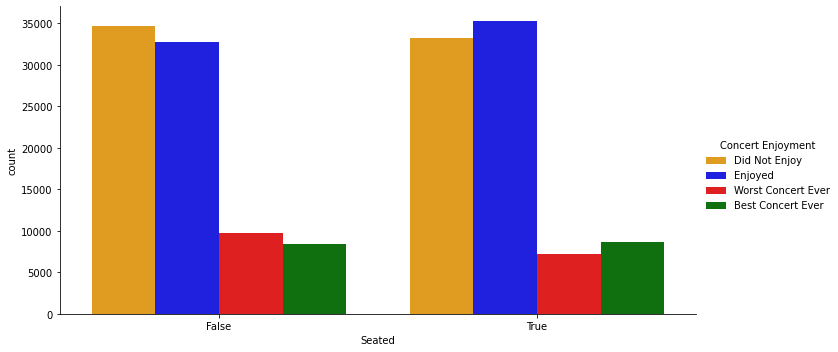

In [ ]:
sns.catplot(data=df_train, x="Same Country", hue="Concert Enjoyment", kind="count",  height=5, aspect=2, palette=colors_labels)
sns.catplot(data=df_train, x="standing_small", hue="Concert Enjoyment", kind="count",  height=5, aspect=2, palette=colors_labels)
sns.catplot(data=df_train, x="Rain_Inside", hue="Concert Enjoyment", kind="count",  height=5, aspect=2,palette=colors_labels)
sns.catplot(data=df_train, x="Rain", hue="Concert Enjoyment", kind="count",  height=5, aspect=2,palette=colors_labels)
sns.catplot(data=df_train, x="Inside Venue", hue="Concert Enjoyment", kind="count",  height=5, aspect=2,palette=colors_labels)
sns.catplot(data=df_train, x="Seated", hue="Concert Enjoyment", kind="count",  height=5, aspect=2,palette=colors_labels)

In [ ]:
# one hot encoding of categorical classes
columns_to_label = []
columns_to_onehot = ["Concert Goer Country of Origin", "Band Country of Origin", "Band Genre", "Band Name"]

for cat in columns_to_onehot:
    df_train = pd.get_dummies(df_train, prefix=cat, columns=[cat], drop_first = False)
    df_test = pd.get_dummies(df_test, prefix=cat, columns=[cat], drop_first = False)
    
# get labels only for training data
gen_le = LabelEncoder()
gen_labels = gen_le.fit_transform(df_train["Concert Enjoyment"])
df_train["Label"] = gen_labels
label_mapping = dict(zip(df_train["Concert Enjoyment"], gen_labels))
drop_keys.append("Concert Enjoyment")
drop_keys.append("Label")
y_train = df_train['Label']

# get training data
features_keys = set(df_train.keys()).difference(set(drop_keys))
features_keys = set(df_test.keys()).difference(set(drop_keys))
X_train = df_train[features_keys]
X_test = df_test[features_keys]
X_train = X_train.astype({"Rain_Inside": "float", 'Seated':'float','Rain':'float', "Inside Venue":"float", "Same Country":"float", "standing_small":"float"})
X_test = X_test.astype({"Rain_Inside": "float", 'Seated':'float','Rain':'float', "Inside Venue":"float", "Same Country":"float", "standing_small":"float"})

#X.to_numpy()
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(170000, 87) (30000, 87)


## 1.2 Final model
Our final model is a bagging model composed of an XGBoost classifier, a random forest classifier
and a recommender system. The hyperparameters used in for the two classifiers a results of the randomized search made in section 2 of this notebook.

***Important*** : You must execute the cells of the whole section 1 if you want to generate the final predictions.

In [ ]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler, SimpleFill, IterativeSVD, MatrixFactorization
# recommender
class Recommender():
  def __init__(self, m, n, labbel_mapping):
    self.rating_M = np.empty(shape = (m, n))
    self.rating_M[:] = np.nan
    #self.average_M = np.zeros(shape = (m, n))
    # reverse mapping direction
    self.labbel_mapping =  {v: k for k, v in label_mapping.items()}

  def get_matrix(self, M):
    print(M.shape)
    for i in M:
        self.rating_M[i[1], i[2]] = i[0]
        #self.average_M[i[1], i[2]] += 1
    
    #self.rating_M = self.rating_M # / self.average_M

  def fill_matrix(self, mode="Simple"):
    if mode == "Simple":
      self.rating_M = SimpleFill().fit_transform(self.rating_M)
    if mode == "MF":
      self.rating_M = MatrixFactorization().fit_transform(self.rating_M)

    self.rating_M = np.round(self.rating_M)

  def predict(self, X):
    predictions = []
    for user_id, concert_id in zip(X["Goer_ID"], X["CE_ID"]):
      predictions.append(self.labbel_mapping[self.rating_M[user_id, concert_id]])
    return predictions



In [ ]:
df_reg= df_train[["Label", "Goer_ID", "CE_ID"]]
M = df_reg.to_numpy()
unique_users, counts_users = np.unique(df_reg["Goer_ID"].to_numpy(), return_counts=True)
unique_concerts, counts_concerts = np.unique(df_reg["CE_ID"].to_numpy(), return_counts=True)

# shape of matrix: rows are all users, cols are all concerts
m = unique_users[-1] +1
n = unique_concerts[-1] + 1

recommender = Recommender(m , n, label_mapping)
recommender.get_matrix(M)
recommender.fill_matrix(mode="MF") # needs colab with 25GB RAM

(170000, 3)
[MatrixFactorization] Iter 10: observed MAE=0.627435 rank=40


In [ ]:
# fit model on training data with hyperparameters of search
# random forest: {'n_estimators': 200, 'max_depth': 35}
# xgb: colsample_bytree=0.923089382562215, learning_rate=0.12410254660260117, max_depth=11, min_child_weight=6, n_estimators=128, subsample=0.7833194911736164
rf_model = RandomForestClassifier(n_estimators= 200, max_depth=35, random_state=0)
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_classes=4, colsample_bytree=0.9230, learning_rate= 0.124, max_depth=11, min_child_weight=6, n_estimators= 128)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train,y_train)

In [ ]:
# getting predicitons for test data
def get_ensemble_prediction(pred1, pred2, pred3):
  predictions = []
  for i in range(len(pred1)):
    p1 = recommender.labbel_mapping[pred1[i]]
    p2 = recommender.labbel_mapping[pred2[i]]
    p3 = pred3[i]
    values, counts = np.unique(np.array([p1,p2,p3]), return_counts=True)
    if len(values) == 3:
      predictions.append(p1)
    else:
      predictions.append(values[np.argmax(counts)])

  return predictions

def write_to_csv(df, predictions):
  header = ["Id", "Predicted"]
  file = open("submission.csv", 'w')
  writer = csv.writer(file)
  writer.writerow(header)
  for row in zip(df["Id"], predictions):
      writer.writerow(row)
  file.close()

# prediction for test data
pred_recom = recommender.predict(X_test)
pred_rf = rf_model.predict(X_test)
pred_xgb = xgb_model.predict(X_test)

# get the voting predictions of the three classifiers
predictions = get_ensemble_prediction(pred_xgb, pred_rf, pred_recom)
write_to_csv(df_test, predictions)

# 2 RandomizedSearch to find best hyperparameters for XGBCLassifier and RandomForestClassifer 

It should be noted that the XGBoostClassifier and the RandofmForestClassifier used in section 1.2 of the notebook  to make the best predictions are tuned using the search results from randomized search made in this section.

In [ ]:
# random hyperparamter search XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_classes=4)
param_dist = {'n_estimators': stats.randint(50, 300),
              'learning_rate': stats.uniform(0.3, 0.3),
              'subsample': stats.uniform(0.7, 0.2),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.5),
              'min_child_weight': [1, 2, 3, 4]
             }
random_xgb = RandomizedSearchCV(xgb_model, param_distributions = param_dist, n_iter = 20, cv = 3, verbose=3, random_state=42, n_jobs = 1)
random_xgb.fit(X_train, y_train)
print("\n The best score across ALL searched params:\n", random_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n", random_xgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.5804285838459496, max_depth=5, min_child_weight=4, n_estimators=70, subsample=0.4404167763981929; total time= 1.2min
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.5804285838459496, max_depth=5, min_child_weight=4, n_estimators=70, subsample=0.4404167763981929; total time= 1.1min
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.5804285838459496, max_depth=5, min_child_weight=4, n_estimators=70, subsample=0.4404167763981929; total time= 1.1min
[CV] END colsample_bytree=0.5779972601681014, learning_rate=0.044850167300919674, max_depth=7, min_child_weight=4, n_estimators=153, subsample=0.9372653200164409; total time= 2.5min
[CV] END colsample_bytree=0.5779972601681014, learning_rate=0.044850167300919674, max_depth=7, min_child_weight=4, n_estimators=153, subsample=0.9372653200164409; total time= 2.6min
[CV] END colsample_bytree=0.5779972601

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 7


 The best score across ALL searched params:
 0.6592294246477733

 The best parameters across ALL searched params:
 {'colsample_bytree': 0.8925879806965068, 'learning_rate': 0.12980426929501584, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 113, 'subsample': 0.7200866039231819}


In [ ]:
 #{'colsample_bytree': 0.8925879806965068, 'learning_rate': 0.12980426929501584, #
#'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 113, 'subsample': 0.7200866039231819}

# random hyperparamter search XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_classes=4)
param_dist2 = {'n_estimators': stats.randint(100, 130),
              'learning_rate': stats.uniform(0.1, 0.1),
              'subsample': stats.uniform(0.7, 0.1),
              'max_depth': [8,9,10,11],
              'colsample_bytree': stats.uniform(0.9, 0.1),
              'min_child_weight': [3,4,5,6,7]
             }
random_xgb2 = RandomizedSearchCV(xgb_model, param_distributions = param_dist2, n_iter = 20, cv = 3, verbose=3, random_state=42, n_jobs = 1)
random_xgb2.fit(X_train, y_train)
print("\n The best score across ALL searched params:\n", random_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n", random_xgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END colsample_bytree=0.9374540118847363, learning_rate=0.19507143064099164, max_depth=10, min_child_weight=7, n_estimators=120, subsample=0.7156018640442436;, score=0.660 total time= 5.2min
[CV 2/3] END colsample_bytree=0.9374540118847363, learning_rate=0.19507143064099164, max_depth=10, min_child_weight=7, n_estimators=120, subsample=0.7156018640442436;, score=0.662 total time= 5.4min
[CV 3/3] END colsample_bytree=0.9374540118847363, learning_rate=0.19507143064099164, max_depth=10, min_child_weight=7, n_estimators=120, subsample=0.7156018640442436;, score=0.665 total time= 5.5min
[CV 1/3] END colsample_bytree=0.9155994520336203, learning_rate=0.10580836121681995, max_depth=11, min_child_weight=7, n_estimators=103, subsample=0.714286681792194;, score=0.657 total time= 5.1min
[CV 2/3] END colsample_bytree=0.9155994520336203, learning_rate=0.10580836121681995, max_depth=11, min_child_weight=7, n_estimators=103, subsamp

KeyboardInterrupt: ignored

In [ ]:
# hyperparamter search Random Forest
n_estimators = [int(x) for x in np.linspace(start = 80, stop = 200, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 70, num = 15)]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
pprint(random_grid)

{'max_depth': [10, 14, 18, 22, 27, 31, 35, 40, 44, 48, 52, 57, 61, 65, 70],
 'n_estimators': [80, 93, 106, 120, 133, 146, 160, 173, 186, 200]}


In [ ]:
clf_rf = RandomForestClassifier()
random_rf = RandomizedSearchCV(estimator = clf_rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=3, random_state=42, n_jobs = 1)
rf_random.fit(X_train, y_train)
print("\n The best score across ALL searched params:\n", rf_random.best_score_)
print("\n The best parameters across ALL searched params:\n", rf_random.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END .....................max_depth=40, n_estimators=120; total time=  51.8s
[CV] END .....................max_depth=40, n_estimators=120; total time=  52.4s
[CV] END .....................max_depth=40, n_estimators=120; total time=  50.7s
[CV] END .....................max_depth=14, n_estimators=186; total time=  39.7s
[CV] END .....................max_depth=14, n_estimators=186; total time=  40.4s
[CV] END .....................max_depth=14, n_estimators=186; total time=  40.3s
[CV] END .....................max_depth=57, n_estimators=186; total time= 1.4min
[CV] END .....................max_depth=57, n_estimators=186; total time= 1.3min
[CV] END .....................max_depth=57, n_estimators=186; total time= 1.3min
[CV] END .....................max_depth=40, n_estimators=186; total time= 1.3min
[CV] END .....................max_depth=40, n_estimators=186; total time= 1.3min
[CV] END .....................max_depth=40, n_es

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=1,
                   param_distributions={'max_depth': [10, 14, 18, 22, 27, 31,
                                                      35, 40, 44, 48, 52, 57,
                                                      61, 65, 70],
                                        'n_estimators': [80, 93, 106, 120, 133,
                                                         146, 160, 173, 186,
                                                         200]},
                   random_state=42, verbose=2)

# 3 - Old exploration
This part is not important, it is the leftover code from past exploration. You can just skip this part.

In [ ]:
df = encode_data(df)
X_train, X_val, y_train, y_val = get_train_test(df)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

Id                                170000
Band Name                             54
Band Genre                             8
Band Country of Origin                 4
Band Debut                            34
Concert ID                          1000
Concert Attendance                    18
Inside Venue                           2
Rain                                   2
Seated                                 2
Personnality Trait 1                2000
Personnality Trait 2                2163
Personnality Trait 3                2205
Personnality Trait 4                2000
Concert Goer Age                      61
Concert Goer ID                     2000
Height (cm)                           51
Concert Goer Country of Origin       152
Concert Enjoyment                      4
dtype: int64
(169830, 229) (169830,)
(170, 229) (170,)


In [ ]:
# use NN as classifier
model = train_neural_network(X_train, y_train, X_val, y_val)
predictions = get_nn_predictions(model, X_val, y_val)

In [ ]:
def train_neural_network(X_train, y_train, X_val, y_val):
  label_mappings = []
  gen_le = LabelEncoder()
  classes = 4
  gen_labels = gen_le.fit_transform(y_train)
  label_mappings.append(dict(zip(y_train, gen_labels)))
  y_train = tf.keras.utils.to_categorical(gen_labels, classes)
  gen_labels = gen_le.fit_transform(y_val)
  y_val = tf.keras.utils.to_categorical(gen_labels, classes)

  input_dim = X_train.shape[1]
  print(input_dim)

  model = Sequential()
  model.add(Dense(60, input_shape=(input_dim,), activation='sigmoid'))
  model.add(Dense(40, activation='sigmoid'))
  model.add(Dense(20, activation='sigmoid'))
  model.add(Dense(10, activation='sigmoid'))
  model.add(Dense(classes, activation='sigmoid'))
  model.summary()

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  X_train = np.asarray(X_train).astype('float32')
  model.fit(X_train, y_train, epochs=20, batch_size=1024, verbose = "auto", validation_data=(X_val, y_val))

  return model

def get_nn_predictions(model, X, y):
  def to_labels(x):
    return np.argmax(x, axis=1)
  def to_class_names(x):
    return 0

  lookupTable, y = np.unique(y, return_inverse=True)
  y_pred = to_labels(model.predict(X))

  print(" Accurarcy: ", accuracy_score(y_pred, y), " F1-Score: ", f1_score(y_pred, y, average="micro"))

  return y_pred


In [ ]:
def encode_data(df, columns_to_onehot, columns_to_label):
  gen_le = LabelEncoder()
  print(df.nunique())
  columns_to_onehot = ["Band Genre", "Band Country of Origin", "Band Name", "Concert Goer Country of Origin"]
  columns_to_label = []

  # label encoding
  label_mappings = []
  for cat in columns_to_label:
    gen_labels = gen_le.fit_transform(df['Band Name'])
    df[cat] = gen_labels
    label_mappings.append(dict(zip(df[cat], gen_labels)))

  # one hot encoding
  for cat in columns_to_onehot:
    df = pd.get_dummies(df, prefix=cat, columns=[cat], drop_first = False)

  return df



In [ ]:

import featuretools as ft

es = ft.EntitySet(id="Id")

es = es.add_dataframe(
    dataframe_name="data",
    dataframe=df,
    index="Id"
)

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="data",
    trans_primitives=["equal"],
    max_depth=2,
)

print(feature_defs)
feature_matrix.keys()



In [ ]:
def get_train_test(df, eval = False, test_size = 0.001, normalize=False, feature_selection=False, k_features = 80):
  gen_le = LabelEncoder()
  # get X_train and y_labels
  drop_keys = ["Concert Enjoyment", "Id", "Concert Goer Country of Origin", "Concert Goer ID", "Label", "Concert ID"]
  #drop_keys = ["Concert Enjoyment", "Label", "Concert Goer ID", "Id"]

  features_keys = set(df.keys()).difference(set(drop_keys))

  X = df[features_keys]
  if not eval:
    gen_labels = gen_le.fit_transform(df["Concert Enjoyment"])
    df["Label"] = gen_labels
    label_mapping = dict(zip(df["Concert Enjoyment"], gen_labels))
    y = df['Label']
    #y= df["Concert Enjoyment"]

  X = X.astype({'Seated':'float','Rain':'float', "Inside Venue":"float"})

  #normalize for neural network
  if normalize:
    X = (X-X.min())/(X.max()-X.min())

  # feature selection
  if feature_selection:
    selector = SelectKBest(mutual_info_regression, k =k_features)
    selector.fit(X, y)
    X = X[X.columns[selector.get_support()]]

  X = X.to_numpy()

  # split into train and validation set
  if not eval:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_val, y_train, y_val
  else:
    return X, None, None, None

In [ ]:
 # get predictions for test data
df_test = pd.read_csv("test.csv")
# fill nans with most frequent value
df_test = df_test.fillna(df_test.mode().iloc[0])

gen_le = LabelEncoder()
df = encode_data(df_test)
X_test, _, _, _ = get_train_test(df, eval= True)
X_test = np.asarray(X_test).astype('float32')
print(X_test.shape)

y_pred = model.predict(X_test)
print(y_pred)

write_to_csv(df,y_pred)

Id                                30000
Band Name                            54
Band Genre                            8
Band Country of Origin                4
Band Debut                           34
Concert ID                         1000
Concert Attendance                   18
Inside Venue                          2
Rain                                  2
Seated                                2
Personnality Trait 1               2000
Personnality Trait 2               2037
Personnality Trait 3               2043
Personnality Trait 4               2000
Concert Goer Age                     61
Concert Goer ID                    2000
Height (cm)                          51
Concert Goer Country of Origin      152
dtype: int64
(30000, 229)
['Best Concert Ever' 'Enjoyed' 'Enjoyed' ... 'Enjoyed' 'Did Not Enjoy'
 'Did Not Enjoy']
